In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [10]:
import mlflow

In [15]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

<Experiment: artifact_location='/home/estevam/dataside/mlops-zoomcamp/02 - Experiment Tracking/mlruns/1', creation_time=1723481053030, experiment_id='1', last_update_time=1723481053030, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [2]:
def pre_processing(path_df: str) -> pd.DataFrame:
    # Load DataFrame
    df = pd.read_parquet(path=path_df)
    
    if 'lpep_pickup_datetime' in df.columns and 'lpep_dropoff_datetime' in df.columns:
        pickup_col, dropoff_col = 'lpep_pickup_datetime', 'lpep_dropoff_datetime'
    elif 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
        pickup_col, dropoff_col = 'tpep_pickup_datetime', 'tpep_dropoff_datetime'
    
    # Transformando valores em datetime e criando a coluna duração
    df[pickup_col] = pd.to_datetime(df[pickup_col])
    df[dropoff_col] = pd.to_datetime(df[dropoff_col])
    df['duration'] = df[dropoff_col] - df[pickup_col]
    df['duration'] = df['duration'].apply(lambda time: time.total_seconds() / 60)
    
    # Filtrando Duração da Viagem
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    
    return df

In [3]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

def transform_variables(
    df: pd.DataFrame,
    dict_vectorizer: DictVectorizer,
):
    # Transformar variáveis categóricas
    df[categorical] = df[categorical].astype(str)

    data_dicts = df[categorical + numerical].to_dict(orient="records")
    X = dict_vectorizer.transform(data_dicts)
    y = df["duration"].values

    return X, y

In [4]:
df_train = pre_processing(
    path_df="data/green_tripdata_2021-01.parquet"
)  # janeiro
df_test = pre_processing(
    path_df="data/green_tripdata_2021-02.parquet"
)  # fevereiro

In [5]:
dict_vectorizer = DictVectorizer()

# Transformação do conjunto de treinamento
df_train[categorical] = df_train[categorical].astype(str)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dict_vectorizer.fit_transform(train_dicts)
y_train = df_train['duration'].values

# Transformação do conjunto de teste usando o mesmo DictVectorizer
X_test, y_test = transform_variables(df_test, dict_vectorizer)


In [12]:
mlflow.sklearn.autolog()
lr = LinearRegression()
lr.fit(X_train, y_train)

2024/08/12 13:39:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'af1e08bc7fa14296b443991ce802f5c3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/12 13:39:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/08/12 13:39:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'sqlite' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


LinearRegression()

In [7]:
y_pred = lr.predict(X_test)

<Axes: ylabel='Count'>

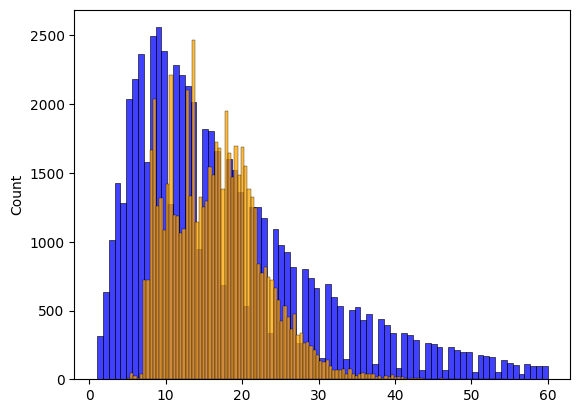

In [8]:
sns.histplot(y_test, legend="actual", color="blue", edgecolor="black")
sns.histplot(y_pred, legend="predict", color="orange", edgecolor="black")

In [9]:
np.sqrt(mean_squared_error(y_test, y_pred))

10.499110710313019